In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd

In [ ]:
edge = pd.read_csv("/content/drive/My Drive/eth-data/edges.csv", header = None, names = ['amount', 'timestamp', 'fromnode', 'tonode'])

In [ ]:
full_data = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/whole_final_dataset.csv')

In [ ]:
edge_df = edge.copy()
edge_df['timestamp'] = pd.to_datetime(edge_df['timestamp'], unit='s')

In [ ]:
# Exhibit the first 5 rows of the node-edge data
edge_df.head()

,amount,timestamp,fromnode,tonode
0,2.344623,2018-05-16 07:01:26,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0x1266f8b9e4dffc9e2f719bf51713f7e714516861
1,0.070000,2017-09-03 18:06:05,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0x806ceb189d36700a97f4e7ecd4fb6c95f2c5a3de
2,0.070000,2017-09-03 18:06:05,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0x806ceb189d36700a97f4e7ecd4fb6c95f2c5a3de
3,5.068543,2017-10-12 11:03:39,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0x3ec4688db6bf8464b0bef30ec2ca7afc7fa7863c
4,5.068543,2017-10-12 11:03:39,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0x3ec4688db6bf8464b0bef30ec2ca7afc7fa7863c


In [ ]:
# Exhibit the first 5 rows of full data
full_data.head()

,idx,node,isp,in_degree,out_degree,pagerank,weightsout,weightsin,numout,numin
0,0,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0,215.0,1624.0,6.168217e-07,14285.789338,15931.196110,215.0,1624.0
1,1,0x1266f8b9e4dffc9e2f719bf51713f7e714516861,0,1.0,1.0,1.333369e-07,2.344203,2.344623,1.0,1.0
2,2,0xbbfaf27674c2eb5d13edc58a40081248d13dcfeb,1,8.0,0.0,8.449769e-07,0.000000,25.268098,8.0,0.0
3,3,0x256fc19e9d8f5be0d451841f218289d1adbbaaa3,0,0.0,1.0,1.331609e-07,0.489485,0.000000,0.0,1.0
4,4,0xb50d0c4cb2c29cc232c96a59e9c65eb82914ec75,0,63.0,166.0,8.827056e-07,19.336007,8.408347,63.0,166.0


In [ ]:
# Drop duplicates in the node-edge data (same account transfer to same another account at same time for several times does not make sense )
edge_df.drop_duplicates(inplace=True)
edge_df.reset_index(drop=True, inplace=True)

In [ ]:
# high sparsity of timestamp data --> extract useful info from it instead
edge_df['timestamp'].dt.year.unique()
edge_df['year'] = edge_df['timestamp'].dt.year
edge_df['hour_of_day'] = edge_df['timestamp'].dt.hour
edge_df['day_of_week'] = edge_df['timestamp'].dt.dayofweek
edge_df['date'] = edge_df['timestamp'].dt.date

In [ ]:
# merge node-edge dataframe with our full data --> to add on isp to our dataset
edge_merge = edge_df.merge(full_data[['node', 'isp']], left_on = "fromnode", right_on = "node")

In [ ]:
# Drop duplicate column "node"
edge_merge = edge_merge.drop("node", axis = 1)

In [ ]:
# transaction count
transaction_frequency = edge_df.groupby('fromnode').size().reset_index(name='transaction_count')
edge_merge = edge_merge.merge(transaction_frequency, left_on = "fromnode", right_on = "fromnode")

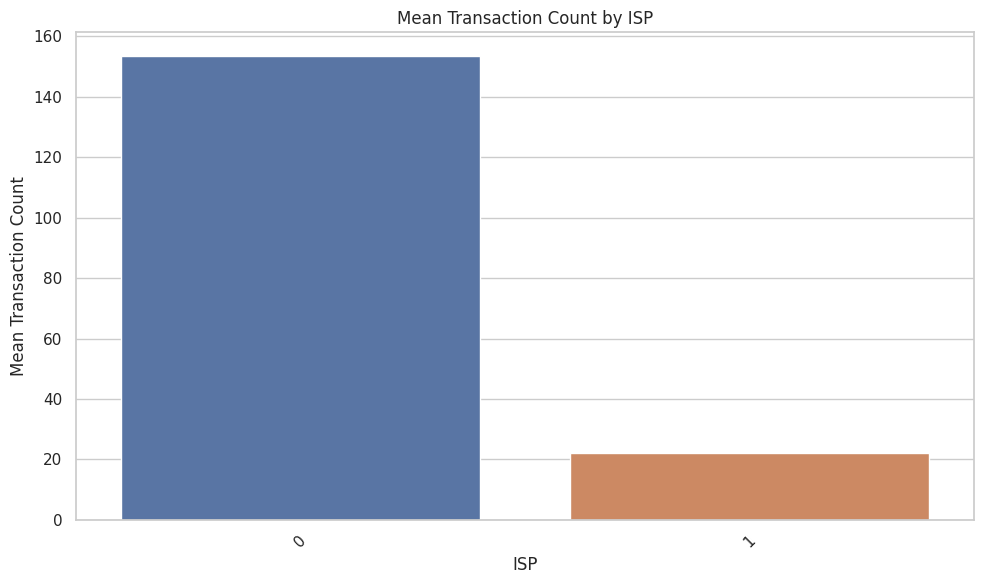

In [ ]:
# EDA -- Explore the relationship between isp & transaction_count




import matplotlib.pyplot as plt
import seaborn as sns
isp_transaction_mode = edge_merge.groupby('isp')['transaction_count'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='isp', y='transaction_count', data=isp_transaction_mode)
plt.xlabel('ISP')
plt.ylabel('Mean Transaction Count')
plt.title('Mean Transaction Count by ISP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# transaction per day
transaction_per_day = edge_merge.groupby(['fromnode', 'date']).size().reset_index(name='transaction_per_day')
edge_merge = edge_merge.merge(transaction_per_day, left_on = ["fromnode", 'date'], right_on = ["fromnode", 'date'])

In [ ]:
transaction_per_day.sort_values(by ="transaction_per_day" , ascending = False)

,fromnode,date,transaction_per_day
1303925,0x564286362092d8e7936f0549571a803b203aaced,2018-01-07,9398
1757369,0x74fe2b73647252c9c997424edeaf631e3f7f2df7,2018-02-09,8748
2616111,0xaf4acad31ab3440ea607a39c8508f187e7da21ce,2017-12-28,5979
528680,0x21e229f2d307d7f232d608d187e4f4c6f56977a1,2018-02-10,5950
2446646,0xa3c1e324ca1ce40db73ed6026c4a177f099b5770,2017-08-13,4950
...,...,...,...
1326491,0x57c687f80390112ce4f341bcf5a6feffb319cf2b,2018-05-31,1
1326492,0x57c68de4472518f00e5a3d7d3301a47eea4cbd4d,2017-09-12,1
1326493,0x57c690206078d992073c861a5d04b24a776d31a4,2018-06-12,1
1326494,0x57c690e6f1be2f9d46bea403cd7f726f8bae5a9f,2017-12-14,1


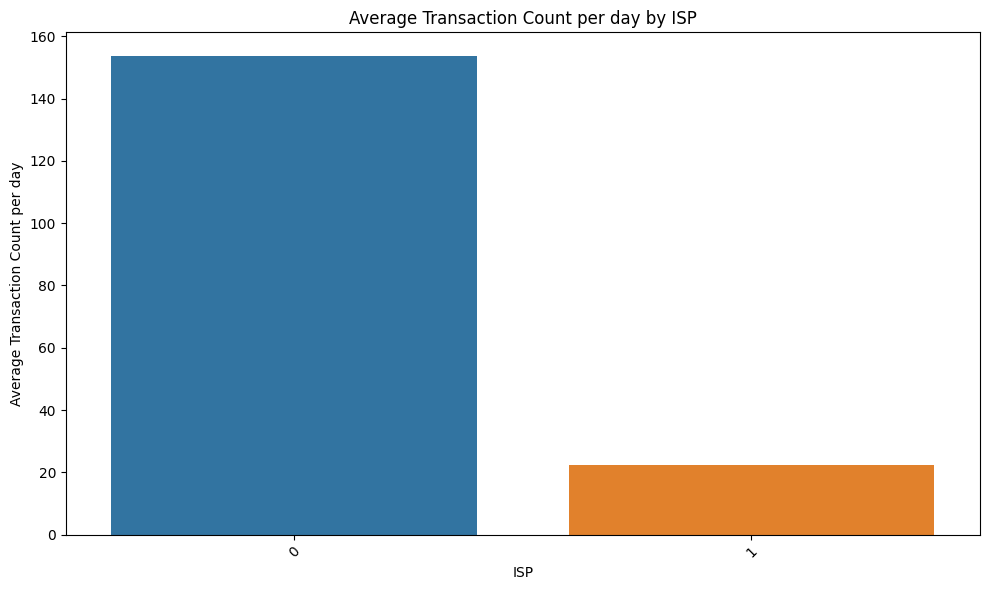

In [ ]:
isp_transaction_mode_per_day = edge_merge.groupby('isp')['transaction_per_day'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='isp', y='transaction_per_day', data=isp_transaction_mode_per_day)
plt.xlabel('ISP')
plt.ylabel('Average Transaction Count per day')
plt.title('Average Transaction Count per day by ISP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
isp_transaction_mode_per_day

,isp,transaction_per_day
0,0,153.637864
1,1,22.228205


In [ ]:
# Frequency of same transaction been made on the same day
same_transaction_frequency = edge_merge.groupby(['fromnode', 'tonode', 'date']).size().reset_index(name='same_transaction_frequency')
edge_merge = edge_merge.merge(same_transaction_frequency, left_on = ['fromnode', 'tonode', 'date'], right_on = ['fromnode', 'tonode', 'date'])

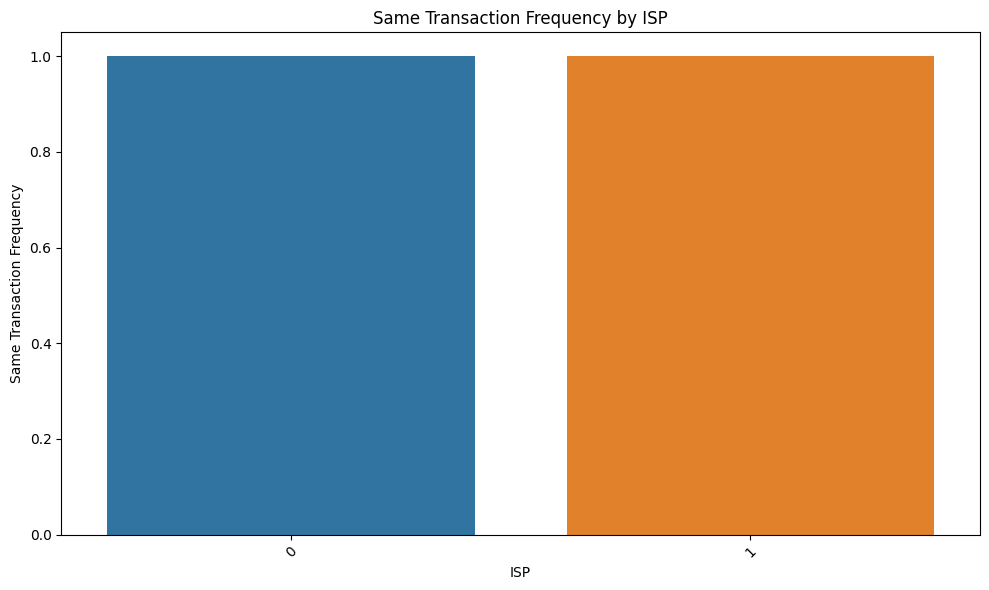

In [ ]:
isp_same_transaction = edge_merge.groupby('isp')['same_transaction_frequency'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='isp', y='same_transaction_frequency', data=isp_same_transaction)
plt.xlabel('ISP')
plt.ylabel('Same Transaction Frequency')
plt.title('Same Transaction Frequency by ISP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/eth-data/edge_new2.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  edge_merge.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
edge_merge1 = edge_merge.copy()

In [ ]:
temporal_features = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/edge_new2.csv')
feature_engineering = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/additional_temporal_features.csv')

In [ ]:
feature_engineering.columns

Index(['fromnode', 'interaction_count', 'active_days',
       'business_hours_interactions_count', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23'],
      dtype='object')

In [ ]:
temporal_features.columns

Index(['Unnamed: 0', 'amount', 'timestamp', 'fromnode', 'tonode', 'year',
       'transaction_count', 'hour_of_day', 'day_of_week', 'date',
       'transaction_per_day', 'same_transaction_frequency'],
      dtype='object')

In [ ]:
feature_engineering.shape

(2113093, 28)

In [ ]:
edge_merge1.shape

(5355155, 11)

In [ ]:
len(edge_merge1['fromnode'].unique())

2113093

In [ ]:
feature_engineering.shape

(2113093, 28)

In [ ]:
merged_df = pd.merge(edge_merge1, feature_engineering, how='left', on='fromnode')

In [ ]:
merged_df.columns

Index(['amount', 'timestamp', 'fromnode', 'tonode', 'year',
       'transaction_count', 'hour_of_day', 'day_of_week', 'date',
       'transaction_per_day', 'same_transaction_frequency',
       'interaction_count', 'active_days', 'business_hours_interactions_count',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

In [ ]:
merged_df.drop_duplicates()

,amount,timestamp,fromnode,tonode,year,transaction_count,hour_of_day,day_of_week,date,transaction_per_day,...,14,15,16,17,18,19,20,21,22,23
0,2.344623,2018-05-16 07:01:26,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0x1266f8b9e4dffc9e2f719bf51713f7e714516861,2018,1327,7,2,2018-05-16,16,...,78.0,86.0,109.0,99.0,57.0,40.0,27.0,12.0,14.0,13.0
1,0.665277,2018-05-16 07:13:38,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0xd8545c53205b23bbef426dd8c988027b4ed5004e,2018,1327,7,2,2018-05-16,16,...,78.0,86.0,109.0,99.0,57.0,40.0,27.0,12.0,14.0,13.0
2,1.690119,2018-05-16 05:54:24,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0xe26850456ed6c76d3fccffb3e798870cb3f5ba70,2018,1327,5,2,2018-05-16,16,...,78.0,86.0,109.0,99.0,57.0,40.0,27.0,12.0,14.0,13.0
3,2.217359,2018-05-16 05:59:48,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0xf86b0a43292b65f67117d4e5ce9a5c9c3a050760,2018,1327,5,2,2018-05-16,16,...,78.0,86.0,109.0,99.0,57.0,40.0,27.0,12.0,14.0,13.0
4,4.995000,2018-05-16 06:28:19,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,0xec1008e385a9a0808ae85ba122b1d600adcd9f0c,2018,1327,6,2,2018-05-16,16,...,78.0,86.0,109.0,99.0,57.0,40.0,27.0,12.0,14.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355150,0.580161,2018-03-23 06:02:02,0x6ba8ad37e285e66c466505236d4e34a6cc3aeee3,0x2abda9c2ee5749c9d561dc4c8089f9f175c02fd7,2018,1,6,4,2018-03-23,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5355151,0.019517,2018-03-15 16:55:48,0x55844143c61396c103e8e3e53371c293842436c2,0x2abda9c2ee5749c9d561dc4c8089f9f175c02fd7,2018,1,16,3,2018-03-15,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5355152,0.400000,2018-05-20 09:32:24,0x0f4153c9e7e34528960628d827a11d522f7641a9,0x2abda9c2ee5749c9d561dc4c8089f9f175c02fd7,2018,1,9,6,2018-05-20,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5355153,0.010960,2018-07-26 12:58:54,0x5462733634994f5f9ad258de7bd9aeb6c8caceeb,0x203c94e654a4cd9f484020b1efdbef4c152dfed7,2018,1,12,3,2018-07-26,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
merged_df.to_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/merged_temporal_features.csv',index=False)